<a href="https://colab.research.google.com/github/DLROM-hub/PredictiveDigitalTwins/blob/main/Application%20to%20Digital%20Twins/Digital%20Twin%20simulation%20(solution).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Toy example**: Air pollution minimization

### Setting up the code

In [ ]:
# Importing / installing auxiliary libraries
import sys
import os

# DL-ROMs package: a Python library for deep learning based ROMs
try:
     from dlroms import*
except:
     !pip -q install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

# Course source code (auxiliary functions, datasets, etc.)
path = "/content/PredictiveDigitalTwins/Application to Digital Twins/"
if(not os.path.isdir(path)):
  ! git clone --quiet https://github.com/DLROM-hub/PredictiveDigitalTwins.git > /dev/null

sys.path.append(path)
from IPython.display import clear_output as clc
clc()
print("Notebook ready.")

Notebook ready.


## **Problem definition**
**A given factory is asked to adjust its production process according to weather conditions, with the objective of minimizing the air pollution over a nearby city. The factory consists of 4 main facilities, each coming with its own chimney.**
</br></br></br>
Let $\Omega\subset\mathbb{R}^{2}$ be a suitable region containing both the city and the factory, together with all its facilities. Let $u:\Omega\to[0,+∞)$ denote the pollutant concentration across $\Omega$. Let $D\subset\Omega$ represent the city. We model the air pollution as the solution to the following parametrized advection-diffusion problem
$$$$
$$-\Delta u + \mathbf{b}_{\theta}\nabla u = \sum_{i=1}^{4}d_{i}\delta_{x_{i}},$$
$$$$
where $x_{i}\in\Omega$ is the location of the $i$th chimney,  $\mathbf{b}_{\theta}=[\cos\theta,\sin\theta]$ models the wind field, $\theta$ is the direction of the wind, and $d_{i}$ is a production coefficient. Here $\delta_{x_{i}}$ is a suitable forcing term, localized and centered ad $x_{i}$.


Given a weather condition, exemplified by the wind direction $\theta$, the factory needs to adjust the production rates $d_{1},d_{2},d_{3},d_{4}$ across the 4 facilities as to:

$\quad\quad$ i) **fulfill the production demand**, i.e. ensuring that $\sum_{i=1}^{4}d_{i}=40$;

$\quad\quad$ ii) **minimize the pollution across the city**, modeled by the functional
$J(u)=\int_{D}u(\mathbf{x})d\mathbf{x}.$

Ideally, we would like $J$ to be below given value. Here, we assume the legal value of air pollution to be 0.1.
</br></br>
**Note 1**: to simulate a real-world scenario, we assume weather conditions to be unknown (and to evolve over time). In particular, the actual direction of the wind field has to be estimated from *sensor measurements*.

**Note 2**: we would like the adjustments to the production stream to happen *in real-time*.

## **Full order model** (FOM solver)
We consider a FOM solver based on the Finite Element method. Solutions are discretized over a structured triangular mesh. The solver is available in the $\texttt{AirPollutionEquation.py}$ module. Solutions can be plotted using the $\texttt{dlroms.fespaces}$ library (imported as "fe").

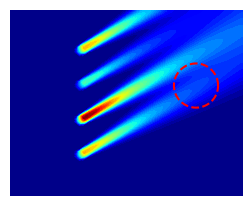

In [ ]:
# Example of a single call to the FOM solver
from AirPollutionEquation import FOMsolver, FOMspace
from numpy import pi
u = FOMsolver(10, 14, 6, 10, pi/6)
clc()

from AirPollutionEquation import plotTarget
plt.figure(figsize = (3, 3))
fe.plot(u, FOMspace, cmap = 'jet', levels = 50)
plotTarget()

In [ ]:
# Cost functional that we are willing to minimize
from AirPollutionEquation import PollutionLevel
PollutionLevel(u)

0.9195914099151287

In [ ]:
# Loading FOM simulations
from AirPollutionEquation import loadData
mu, u = loadData()

# Transfering to Pytorch
mu = CPU.tensor(mu)
u = CPU.tensor(u)

## **Reduced order model** (DL-based surrogate)
We can use any ROM of choice. If none, we can load the pretrained one that is available on Github.

In [ ]:
# Loading the ROM from Github (see AirROM.py for an overview on its implementation)
from AirROM import downloadROM
ntrain = int(0.8*len(u))

ROM = downloadROM(mu[:ntrain], u[:ntrain])
clc()

In [ ]:
# Performance check
l2 = L2(FOMspace)
clc()
mutrue, utrue = mu[ntrain:], u[ntrain:]
uROM = ROM(mutrue)
ROMerror = mre(l2)(utrue, uROM)
print("ROM error: %s." % num2p(ROMerror))

ROM error: 3.50%.


## **Digital twin simulation**
Two main ingredients:

1) a reconstruction routine, for finding $\theta$ given the sensor measurements;

2) an optimization routine, for choosing $d_{1},\dots,d_{4}$.

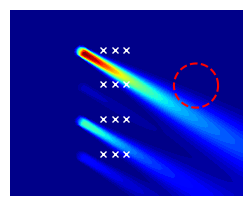

In [ ]:
## Pollutant distribution, protected area (city) and sensors location (white crosses)

import numpy as np
isensors = [4321, 6496,  8671, 10396, 3809, 5864, 8127, 9972, 3329, 5264, 7551, 9516]
sensors = fe.coordinates(FOMspace)[isensors]
plt.figure(figsize = (3, 3))
fe.plot(utrue[0], FOMspace, cmap = 'jet', levels = 50)
plt.plot(*sensors.T, 'x', color = 'white', markersize = 5)
plotTarget()

In [ ]:
# Inverse problem (retrieving theta from sensor measurements)

def findTheta(d1, d2, d3, d4, sensors_data, thetamin = -pi/4.0, thetamax = pi/4.0):
  """Given the current state and the sensor measurments, this function should output
  an estimate for the wind direction theta.

  Input:
    d1  (float)   production rate for factory 1
    ..  ..        ..
    d4  (float)   production rate for factory 4

    sensors_data  (torch.tensor)   1D tensor listing sensor values (should have lenght = # of sensors)

    thetamin      (float) minimum wind angle, to restrict the search. Optional. Defaults to -pi/4.
    thetamax      (float) maximum wind angle, to restrict the search. Optional. Defaults to pi/4.
  """

  thetas = np.linspace(thetamin, thetamax, 1000)
  candidates = CPU.zeros(1000, 5)
  candidates[:,-1] = CPU.tensor(thetas)
  candidates[:, 0] = d1
  candidates[:, 1] = d2
  candidates[:, 2] = d3
  candidates[:, 3] = d4

  solutions = ROM(candidates)
  measurements_gap = ((solutions[:, isensors] - sensors_data.reshape(1, -1))**2).sum(axis = -1)
  return thetas[measurements_gap.argmin()]

In [ ]:
# Optimization problem (choosing the best production policy)

def bestPolicy(theta, d1 = 10.0, d2 = 10.0, d3 = 10.0, d4 = 10.0):
  """Given the wind direction, it should return an optimal production rate for the four factories.

  Input:
    theta (float) current wind angle
    d1  (float)   initial guess for the production rate of factory 1. Optional. Defaults to 10.
    ..  ..        ..
    d4  (float)   initial guess for the production rate of factory 4. Optional. Defaults to 10.

    sensors_data  (torch.tensor)   1D tensor listing sensor values (should have lenght = # of sensors)

    thetamin      (float) minimum wind angle, to restrict the search. Optional. Defaults to -pi/4.
    thetamax      (float) maximum wind angle, to restrict the search. Optional. Defaults to pi/4.
  """


  from scipy.optimize import minimize

  # To handle the production constraint, d1+..+d4 = 40, we rely on a re-parametrization trick.
  # We let y_i = sigmoid(z_i) and d_i = 40*y_i/(y_1+...+y_4).
  #
  # Viceversa, given d_i, we retrieve z_i as z_i = log(d_i/40) - log(1-d_i/40).

  sigmoid = lambda x: 0.5*np.tanh(x)+0.5 # auxiliary transformation, mapping real values onto (0, 1)

  def costFunctional(z):
    d = sigmoid(z)
    d = 40*d/d.sum() # normalization
    parameters = CPU.tensor([list(d) + [theta]])
    state = ROM(parameters).reshape(-1) # Try replacing with FOMsolver(*d, theta) to appreciate the speed up!
    return PollutionLevel(state).item()

  d0 = np.array([d1, d2, d3, d4])/40.0
  z0 = np.log(d0)-np.log(1.0-d0) # logit transform (inverse of sigmoid)

  # To increase our chances of finding the actual minimum, we run two attempts: one starting from
  # the barycenter (d_i = 10), and one from the initial guess.
  # The uniform configuration, z_i = 0.0, is a way to parametrize the case d_i = 10.0.

  min1 = minimize(costFunctional, z0, method = 'Powell') # from given guess
  min2 = minimize(costFunctional, [0.0, 0.0, 0.0, 0.0], method = 'Powell') # from barycenter

  zoptimal = min1['x'] if min1['fun']<min2['fun'] else min2['x'] # pick best

  # Map back from z to d
  doptimal = sigmoid(zoptimal)
  doptimal = 40*doptimal/doptimal.sum()

  return doptimal

### Simulation

In [ ]:
def getSensorMeasurements(d1, d2, d3, d4, theta):
  """This function simulates the collection of real-data. In practice, it should consist in
  the actual retrieval of sensors measurements. Here, for didactical purposes, we use the FOM as
  a ground truth reference.

  Note: since we rely on the FOM as a replacement of the real-world, this will slow-down the code.
  In real applications, this would not happen."""

  state = FOMsolver(d1, d2, d3, d4, thetas[i])
  sensors_data = state[isensors]
  return sensors_data

def getCityPollution(d1, d2, d3, d4, theta):
    """This function simulates the interaction with the city, which measures and reports the air
    pollution level. Once again, for didactical purposes, we use the FOM as a ground truth reference.
    However, we remark that in practical applications the FOM would not be required."""

    state = FOMsolver(d1, d2, d3, d4, thetas[i])
    return PollutionLevel(state)

In [ ]:
# Time simulation

days = 50
thetas = np.linspace(-pi/4.0, pi/4.0, days) # ground truth wind directions over time: we pretend not to know them!!

levels = [] # pollution levels across the 50 days
policies = [] # list of production stream policies in time
th = [] # estimate wind directions

# Initial policy
policies.append([10.0, 10.0, 10.0, 10.0])

for i in range(days):

  print("Running simulation for day %d..." % (i+1))

  # Real-world measurements
  d1, d2, d3, d4 = policies[-1]
  sensors_data = getSensorMeasurements(d1, d2, d3, d4, thetas[i])

  # Digital twin update
  if(i==0):
    estimatedTheta = findTheta(d1, d2, d3, d4, sensors_data)
  else:
    # If at least 1 day has passed, we can limit our search within a neighbourhood, assuming
    # a continuous wind variation
    estimatedTheta = findTheta(d1, d2, d3, d4, sensors_data, estimatedTheta-0.2, estimatedTheta+0.2)
  th.append(estimatedTheta)

  # Optimal control (digital-twin)
  newpolicy = bestPolicy(estimatedTheta, d1, d2, d3, d4)

  # Real-world update
  policies.append(newpolicy)
  d1, d2, d3, d4 = policies[-1]
  pollution = getCityPollution(d1, d2, d3, d4, thetas[i])
  levels.append(pollution)
  clc(wait = True)
print("Simulation complete.")

Simulation complete.


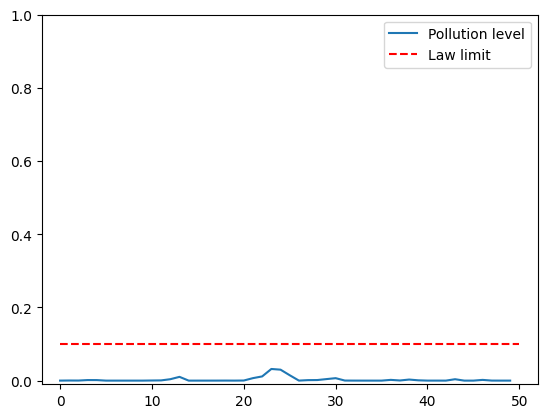

In [ ]:
plot(np.arange(days), levels, label = 'Pollution level')
plot([0, days], [0.1, 0.1], '--r', label = 'Law limit')
plt.axis([-2, days+2, -0.01, 1])
plt.legend()
plt.show()